SEED=1       random_state=SEED

In [1]:

from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

In [120]:
import matplotlib.pyplot as plt
from tensorflow import keras
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
import pandas as pd 
from sklearn.tree import plot_tree
import tensorflow as tf

from sklearn.ensemble import BaggingClassifier

In [3]:
#Raccourci load data 1
fraude = pd.read_table("/Volumes/KINGSTON/M2/Big data mining/Projet_BDM/dataproject.txt",sep=";",decimal=",")

fraude['FlAgImpAye'] = fraude['FlAgImpAye'].astype(str) 
fraude['CodeDecision'] = fraude['CodeDecision'].astype(str) 
fraude['IDAvisAutorisAtionCheque'] = fraude['IDAvisAutorisAtionCheque'].astype(str) 

#Variables actives originales
fraude_act = fraude.iloc[:,2:23]

#fraude2 = data avec dummy 
dummy = pd.get_dummies(fraude['CodeDecision'], prefix='Code' )
dummy

fraude2 = fraude.drop('CodeDecision',axis='columns')
fraude2 = pd.concat([fraude2,dummy],axis=1)

#Train exploitable 
fraude_train = fraude2.iloc[0:1967226]

#Test exploitable 
fraude_test = fraude2.iloc[1967226:len(fraude.index)]

#Train des variables actives exploitable 
fraude_train_act = fraude_train.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Test des variables actives
fraude_test_act = fraude_test.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Variables actives + cible pour les stats desc 
fraude_desc = pd.concat([fraude_train_act,fraude_train['FlAgImpAye']],axis=1)

In [4]:
fraude_train_v = fraude_train.iloc[0:1677541,:]
fraude_train_act_v = fraude_train_act.iloc[0:1677541,:]
fraude_valid = fraude_train.iloc[1677541:1967226,:]
fraude_train_v.FlAgImpAye.value_counts()

0    1673087
1       4454
Name: FlAgImpAye, dtype: int64

In [5]:
fraude_valid.FlAgImpAye.value_counts()

0    288737
1       948
Name: FlAgImpAye, dtype: int64

In [6]:
fraude_test.FlAgImpAye.value_counts()

0    263288
1       855
Name: FlAgImpAye, dtype: int64

In [7]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

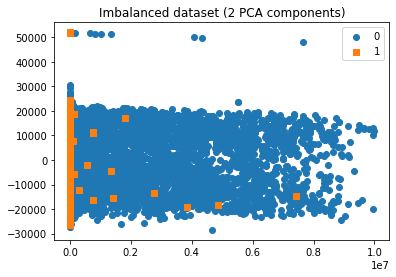

In [8]:
y=fraude_train_v['FlAgImpAye']
pca = PCA(n_components=2)
X = pca.fit_transform(fraude_train_act_v)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

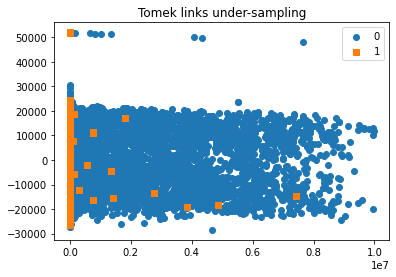

In [9]:
tl = TomekLinks(sampling_strategy="majority") #return_indices=True, ratio='majority'
X_tl, y_tl = tl.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')



In [10]:
y_tl.value_counts()

0    1670527
1       4454
Name: FlAgImpAye, dtype: int64

In [11]:
tl.sample_indices_

array([      0,       1,       2, ..., 1677538, 1677539, 1677540])

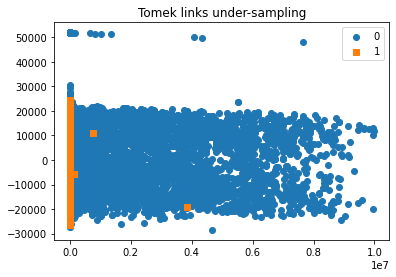

In [12]:
tl2 = TomekLinks(sampling_strategy="all")
X_tl2, y_tl2 = tl2.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl2, y_tl2, 'Tomek links under-sampling')




In [13]:
y_tl2.value_counts()

0    1670527
1       1894
Name: FlAgImpAye, dtype: int64

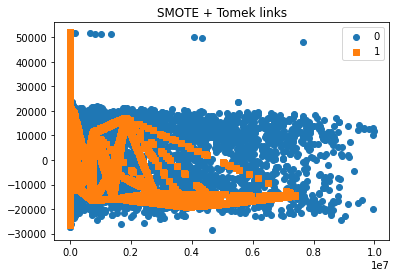

In [14]:
smt = SMOTETomek(n_jobs=-1)
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [15]:
y_smt.value_counts()

1    1633553
0    1633553
Name: FlAgImpAye, dtype: int64

In [ ]:
#X_smt2, y_smt2 = smt.fit_sample(fraude_train_act_v, fraude_train_v.FlAgImpAye)

#y_smt2.value_counts()

In [16]:


#-----------------ARBRE-------------------------

ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#ytest_arbre_red = ytest_keras
#xtest_arbre_red = xtest_keras
#test_arbre_red = pd.concat([xtest_arbre_red,fraude_test['FlAgImpAye']],axis=1)

yvalid_arbre = fraude_valid['FlAgImpAye']
xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
valid_arbre = fraude_valid


--------------------------------------ARBRE DE DECISION----------------------------

In [24]:
def calcul_F(mat):
    
    TP= mat[0,0]
    FN= mat[0,1]
    FP= mat[1,0]
    #F= 2TP / 2T P + F N + F P
    F= 2*TP/(2*TP+FN+FP)
    return(F)

In [20]:
DT = DecisionTreeClassifier(class_weight='balanced',random_state=1)
DT.fit(X = xtrain_arbre_red, y = ytrain_arbre_red)

DecisionTreeClassifier(class_weight='balanced')

In [21]:
#prédiction sur l'échantillon de validation
predFirstDT = DT.predict(X=xvalid_arbre)
#distribution des predictions
 
print(np.unique(predFirstDT,return_counts=True))

(array(['0', '1'], dtype=object), array([288859,    826]))


In [23]:
print(metrics.confusion_matrix(yvalid_arbre,predFirstDT,labels=['1','0']))

[[    49    899]
 [   777 287960]]


[[    49    899]
 [   777 287960]]

In [25]:
#F= 2TP / 2T P + F N + F P

calcul_F(metrics.confusion_matrix(yvalid_arbre,predFirstDT,labels=['1','0']))
#0.061452513966480445

0.0552423900789177

In [26]:
print(metrics.roc_auc_score(yvalid_arbre,predFirstDT))

0.5244983667337813


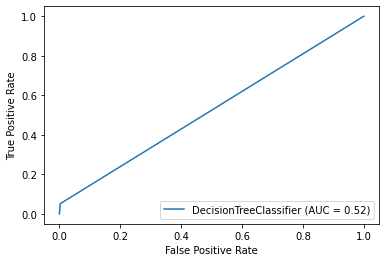

In [27]:
metrics.plot_roc_curve(DT, xvalid_arbre, yvalid_arbre)  
plt.show()  

RANDOM UNDERSAMPLING

In [29]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler()#sampling_strategy='majority'

In [30]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])

In [31]:
# summarize class distribution
print(Counter(y_under))

Counter({'0': 4454, '1': 4454})


In [32]:
undersample2 = RandomUnderSampler(sampling_strategy='all')#
X_under2, y_under2 = undersample2.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])

In [33]:
print(Counter(y_under2))

Counter({'0': 4454, '1': 4454})


In [34]:
#from imblearn.combine import SMOTEENN

#sme = SMOTEENN(random_state=42)
#X_res, y_res = sme.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])
#print('Resampled dataset shape %s' % Counter(y_res))

In [35]:
#from imblearn.over_sampling import ADASYN

#ada = ADASYN(sampling_strategy='minority',random_state=42)
#X_res, y_res = ada.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])
#print('Resampled dataset shape %s' % Counter(y_res))

ARBRE DE DECISION AVEC RANDOM UNDER

In [37]:
DT2 = DecisionTreeClassifier(class_weight='balanced',random_state=1)
DT2.fit(X = X_under, y = y_under)

DecisionTreeClassifier(class_weight='balanced')

In [38]:
#prédiction sur l'échantillon de validation
predDTunder = DT2.predict(X=xvalid_arbre)
#distribution des predictions
 
print(np.unique(predDTunder,return_counts=True))

(array(['0', '1'], dtype=object), array([186106, 103579]))


In [40]:
print(metrics.confusion_matrix(yvalid_arbre,predDTunder,labels=["1", "0"]))

[[   646    302]
 [102933 185804]]


In [41]:
calcul_F(metrics.confusion_matrix(yvalid_arbre,predDTunder,labels=["1", "0"]))

0.012360442756417003

In [42]:
print(metrics.roc_auc_score(yvalid_arbre,predDTunder))

0.6624703135665677


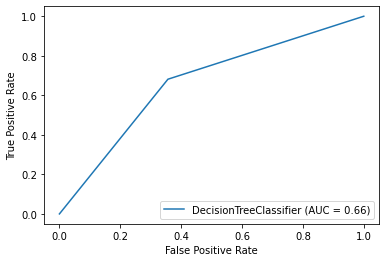

In [43]:
metrics.plot_roc_curve(DT2, xvalid_arbre, yvalid_arbre)  
plt.show() 

In [44]:
metrics.accuracy_score(yvalid_arbre,predDTunder)

0.6436301499905069

In [45]:
#importance des variables
impVarDT2={"Variable":X_under.columns,"Importance":DT2.feature_importances_} 
print(pd.DataFrame(impVarDT2).sort_values(by="Importance",ascending=False))

          Variable  Importance
6       ScoringFP2    0.185898
4             D2CB    0.161215
17           Heure    0.112898
9    TAuxImpNB_CPM    0.091879
7       ScoringFP3    0.080078
0          MontAnt    0.076885
5       ScoringFP1    0.067454
15      CA3TRetMtt    0.063893
8     TAuxImpNb_RB    0.049277
3   VerifiAnceCPT3    0.035154
16           CA3TR    0.027317
12     DiffDAteTr1    0.020318
10    EcArtNumCheq    0.005770
2   VerifiAnceCPT2    0.005362
14     DiffDAteTr3    0.003677
19          Code_2    0.003075
13     DiffDAteTr2    0.003073
1   VerifiAnceCPT1    0.002475
18          Code_0    0.002404
11    NbrMAgAsin3J    0.001700
20          Code_3    0.000199


In [46]:
#importance des variables
impVarDT={"Variable":xtrain_arbre_red.columns,"Importance":DT.feature_importances_} 
print(pd.DataFrame(impVarDT).sort_values(by="Importance",ascending=False))

          Variable  Importance
6       ScoringFP2    0.181547
7       ScoringFP3    0.178315
17           Heure    0.118170
4             D2CB    0.084391
0          MontAnt    0.081432
9    TAuxImpNB_CPM    0.076469
5       ScoringFP1    0.075463
15      CA3TRetMtt    0.059558
8     TAuxImpNb_RB    0.052182
3   VerifiAnceCPT3    0.033055
16           CA3TR    0.021581
12     DiffDAteTr1    0.019500
13     DiffDAteTr2    0.004138
10    EcArtNumCheq    0.003594
18          Code_0    0.003090
2   VerifiAnceCPT2    0.002744
1   VerifiAnceCPT1    0.002208
19          Code_2    0.001191
11    NbrMAgAsin3J    0.000768
14     DiffDAteTr3    0.000537
20          Code_3    0.000068


ARBRE DE DECISION RANDOM UNDER + variation nb règles

In [52]:
DT3 = DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes = 5,random_state=1)
DT3.fit(X = X_under, y = y_under)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=5)

In [53]:
#prédiction sur l'échantillon de validation
predDTunder3 = DT3.predict(X=xvalid_arbre)
#distribution des predictions
 
print(np.unique(predDTunder3,return_counts=True))

(array(['0', '1'], dtype=object), array([225811,  63874]))


In [54]:
print(metrics.confusion_matrix(yvalid_arbre,predDTunder3,labels=["1", "0"]))

[[   573    375]
 [ 63301 225436]]


In [55]:
calcul_F(metrics.confusion_matrix(yvalid_arbre,predDTunder3,labels=["1", "0"]))

0.017679182993428157

In [56]:
print(metrics.roc_auc_score(yvalid_arbre,predDTunder3))

0.6925981335210972


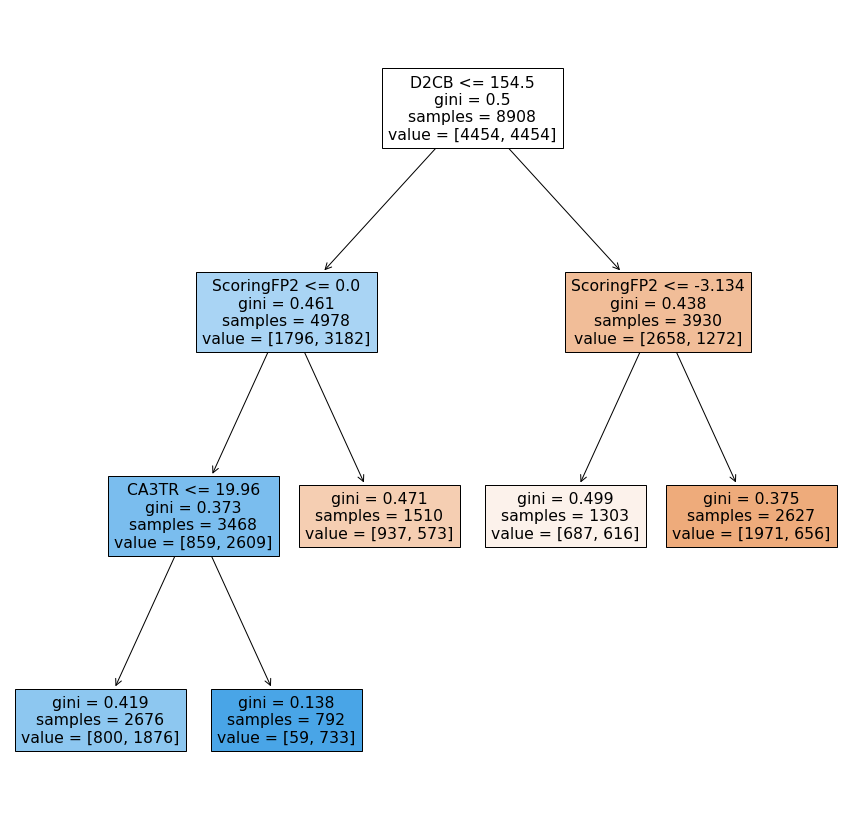

In [57]:
plt.figure(figsize=(15,15))
plot_tree(DT3,feature_names = list(xtrain_arbre_red.columns),filled=True)
plt.show()

In [58]:
varimp = pd.DataFrame(impVarDT).sort_values(by="Importance",ascending=False)
varimp10 = np.array(varimp.Variable.head(10))
varimp10

array(['ScoringFP2', 'ScoringFP3', 'Heure', 'D2CB', 'MontAnt',
       'TAuxImpNB_CPM', 'ScoringFP1', 'CA3TRetMtt', 'TAuxImpNb_RB',
       'VerifiAnceCPT3'], dtype=object)

In [59]:
DT4 = DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes = 6,random_state=1)
DT4.fit(X = X_under[varimp10], y = y_under)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=6)

In [60]:
#prédiction sur l'échantillon de validation
predDTunder4 = DT4.predict(X=xvalid_arbre[varimp10])
#distribution des predictions
 
print(np.unique(predDTunder4,return_counts=True))

(array(['0', '1'], dtype=object), array([224773,  64912]))


In [61]:
print(metrics.confusion_matrix(yvalid_arbre,predDTunder4,labels=["1", "0"]))

[[   583    365]
 [ 64329 224408]]


In [62]:
calcul_F(metrics.confusion_matrix(yvalid_arbre,predDTunder4,labels=["1", "0"]))

0.017704221075007593

In [63]:
print(metrics.roc_auc_score(yvalid_arbre,predDTunder4))

0.6960922283983515


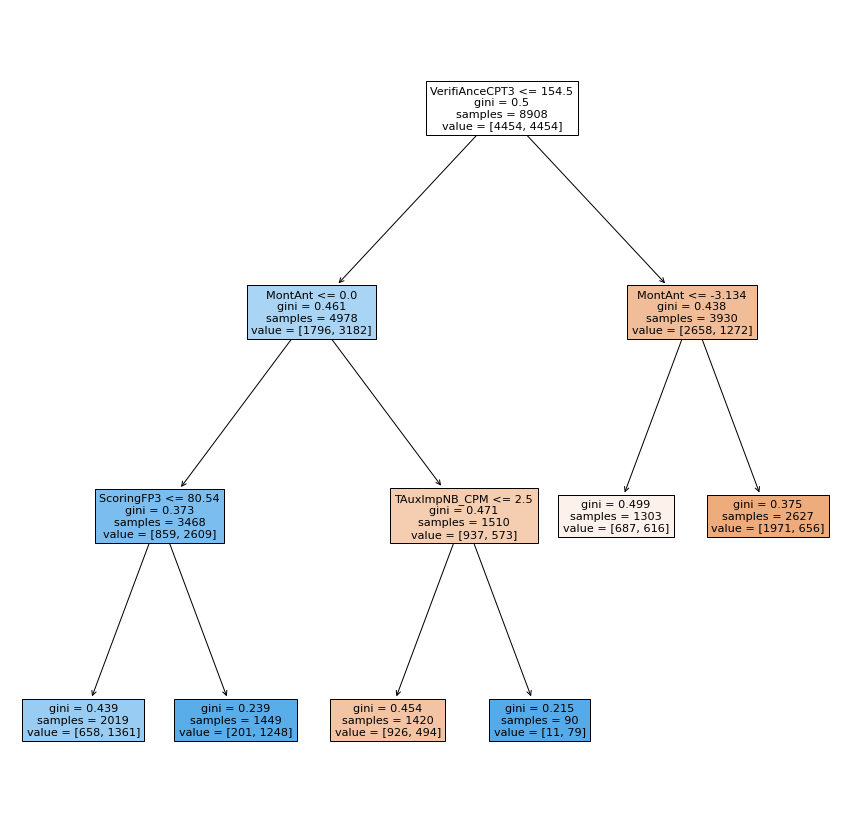

In [64]:
plt.figure(figsize=(15,15))
plot_tree(DT4,feature_names = list(xtrain_arbre_red.columns),filled=True)
plt.show()

--------------------------------------------RESEAUX DE NEURONES---------------------------------------

In [65]:
#ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
#ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
#xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
#train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#yvalid_arbre = fraude_valid['FlAgImpAye']
#xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
#valid_arbre = fraude_valid

ytrain_nn_tl = np.array(ytrain_arbre_red, dtype="uint8")
xtrain_nn_tl = xtrain_arbre_red
yvalid_nn = np.array(yvalid_arbre, dtype="uint8")
xvalid_nn = xvalid_arbre
valid_nn = valid_arbre



In [66]:
counts = np.bincount(ytrain_nn_tl)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(ytrain_nn_tl)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 4454 (0.27% of total)


In [67]:
#Normalisation des donénes 


mean = np.mean(xtrain_nn_tl, axis=0)
xtrain_nn_tl -= mean
xvalid_nn -= mean
std = np.std(xtrain_nn_tl, axis=0)
xtrain_nn_tl /= std
xvalid_nn /= std

In [69]:
modelNN = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(xtrain_nn_tl.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               5632      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 137,473
Trainable params: 137,473
Non-trainable params: 0
________________________________________________

In [70]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='AUC')
]

modelNN.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
#on donne du poids aux fraudes ??? 
class_weight = {0: weight_for_0, 1: weight_for_1}

histoNN=modelNN.fit(
    xtrain_nn_tl,
    ytrain_nn_tl,
    batch_size=2048,
    #nb de fois où on passe le train pour ajuster les param ??
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(xvalid_nn, yvalid_nn),
    class_weight=class_weight,
)

Epoch 1/30
818/818 - 37s - loss: 6.6684e-07 - fn: 1450.0000 - fp: 428098.0000 - tn: 1242429.0000 - tp: 3004.0000 - precision: 0.0070 - recall: 0.6744 - AUC: 0.7829 - val_loss: 0.5714 - val_fn: 248.0000 - val_fp: 72088.0000 - val_tn: 216649.0000 - val_tp: 700.0000 - val_precision: 0.0096 - val_recall: 0.7384 - val_AUC: 0.8186
Epoch 2/30
818/818 - 37s - loss: 6.3005e-07 - fn: 1377.0000 - fp: 362046.0000 - tn: 1308481.0000 - tp: 3077.0000 - precision: 0.0084 - recall: 0.6908 - AUC: 0.8113 - val_loss: 0.4736 - val_fn: 306.0000 - val_fp: 57700.0000 - val_tn: 231037.0000 - val_tp: 642.0000 - val_precision: 0.0110 - val_recall: 0.6772 - val_AUC: 0.8178
Epoch 3/30
818/818 - 36s - loss: 6.2432e-07 - fn: 1367.0000 - fp: 358075.0000 - tn: 1312452.0000 - tp: 3087.0000 - precision: 0.0085 - recall: 0.6931 - AUC: 0.8142 - val_loss: 0.5479 - val_fn: 238.0000 - val_fp: 75034.0000 - val_tn: 213703.0000 - val_tp: 710.0000 - val_precision: 0.0094 - val_recall: 0.7489 - val_AUC: 0.8237
Epoch 4/30
818/818 

818/818 - 39s - loss: 5.8887e-07 - fn: 1208.0000 - fp: 364405.0000 - tn: 1306122.0000 - tp: 3246.0000 - precision: 0.0088 - recall: 0.7288 - AUC: 0.8373 - val_loss: 0.4612 - val_fn: 275.0000 - val_fp: 60442.0000 - val_tn: 228295.0000 - val_tp: 673.0000 - val_precision: 0.0110 - val_recall: 0.7099 - val_AUC: 0.8236
Epoch 27/30
818/818 - 38s - loss: 5.8958e-07 - fn: 1215.0000 - fp: 360371.0000 - tn: 1310156.0000 - tp: 3239.0000 - precision: 0.0089 - recall: 0.7272 - AUC: 0.8365 - val_loss: 0.5554 - val_fn: 224.0000 - val_fp: 82546.0000 - val_tn: 206191.0000 - val_tp: 724.0000 - val_precision: 0.0087 - val_recall: 0.7637 - val_AUC: 0.8224
Epoch 28/30
818/818 - 32s - loss: 5.8883e-07 - fn: 1215.0000 - fp: 368929.0000 - tn: 1301598.0000 - tp: 3239.0000 - precision: 0.0087 - recall: 0.7272 - AUC: 0.8372 - val_loss: 0.5512 - val_fn: 225.0000 - val_fp: 83040.0000 - val_tn: 205697.0000 - val_tp: 723.0000 - val_precision: 0.0086 - val_recall: 0.7627 - val_AUC: 0.8238
Epoch 29/30
818/818 - 33s - 

tp : 682  fn = 266
fp=64843  tn = 223894
AUC=0,8204

In [177]:
plot_metrics(histo_NN)

NameError: name 'plot_metrics' is not defined

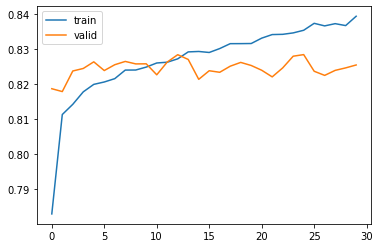

In [71]:
#plot_metrics(modelNN)
plt.plot(histoNN.history['AUC'])
plt.plot(histoNN.history['val_AUC'])
plt.legend(['train', 'valid'], loc='upper left')

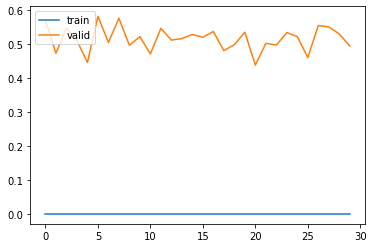

In [72]:

# summarize history for loss
plt.plot(histoNN.history['loss'])
plt.plot(histoNN.history['val_loss'])
plt.legend(['train', 'valid'], loc='upper left')

In [75]:
# evaluate the keras model
l,fn,fp,tn,tp,pr,rap,auc = modelNN.evaluate(xvalid_nn, yvalid_nn)


9053/9053 [==============================] - 21s 2ms/step - loss: 0.4952 - fn: 246.0000 - fp: 71224.0000 - tn: 217513.0000 - tp: 702.0000 - precision: 0.0098 - recall: 0.7405 - AUC: 0.8254: 10s - loss: 0.5151 - fn: 132.0000 - fp: 40641.0000  - ETA: 5s - loss: 0.5064 - fn: 179.0000 - fp: 5 - ETA: 0s - loss: 0.4964 - fn: 236.0000 - fp: 69093.0000 - tn: 209906.0000 - tp: 669.0000 - precision: 0.0096 - recall: 0.73


In [76]:
auc

0.8253819346427917

In [81]:
2*tp/(2*tp+fn*fp)

8.012551627883405e-05

TENTATIVE DU MEME MODELE MAIS EN CHANGEANT POIDS DES CLASSES (https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [100]:
nbok, nbfraude = np.bincount(ytrain_nn_tl)
nbok

1670527

In [101]:
nbfraude

4454

In [107]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / nbok)*(ytrain_nn_tl.size)/2.0 
weight_for_1 = (1 / nbfraude)*(ytrain_nn_tl.size)/2.0


modelNN.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
#on donne du poids aux fraudes ??? 
class_weight = {0: weight_for_0, 1: weight_for_1}

histoNN=modelNN.fit(
    xtrain_nn_tl,
    ytrain_nn_tl,
    batch_size=2048,
    #nb de fois où on passe le train pour ajuster les param ??
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(xvalid_nn, yvalid_nn),
    class_weight=class_weight,
)

Epoch 1/30
818/818 - 32s - loss: 0.5900 - fn: 1937.0000 - fp: 392229.0000 - tn: 1567035.0000 - tp: 3465.0000 - precision: 0.0088 - recall: 0.6414 - AUC: 0.7805 - val_loss: 0.5153 - val_fn: 311.0000 - val_fp: 50724.0000 - val_tn: 238013.0000 - val_tp: 637.0000 - val_precision: 0.0124 - val_recall: 0.6719 - val_AUC: 0.8170
Epoch 2/30
818/818 - 30s - loss: 0.6034 - fn: 1874.0000 - fp: 271296.0000 - tn: 1399231.0000 - tp: 2580.0000 - precision: 0.0094 - recall: 0.5793 - AUC: 0.7714 - val_loss: 0.6018 - val_fn: 301.0000 - val_fp: 53836.0000 - val_tn: 234901.0000 - val_tp: 647.0000 - val_precision: 0.0119 - val_recall: 0.6825 - val_AUC: 0.8126
Epoch 3/30
818/818 - 31s - loss: 0.6105 - fn: 1922.0000 - fp: 262226.0000 - tn: 1408301.0000 - tp: 2532.0000 - precision: 0.0096 - recall: 0.5685 - AUC: 0.7677 - val_loss: 0.5341 - val_fn: 363.0000 - val_fp: 42600.0000 - val_tn: 246137.0000 - val_tp: 585.0000 - val_precision: 0.0135 - val_recall: 0.6171 - val_AUC: 0.8050
Epoch 4/30
818/818 - 33s - loss

Epoch 27/30
818/818 - 35s - loss: 0.5699 - fn: 1825.0000 - fp: 259240.0000 - tn: 1411287.0000 - tp: 2629.0000 - precision: 0.0100 - recall: 0.5903 - AUC: 0.7720 - val_loss: 0.4939 - val_fn: 367.0000 - val_fp: 37605.0000 - val_tn: 251132.0000 - val_tp: 581.0000 - val_precision: 0.0152 - val_recall: 0.6129 - val_AUC: 0.8068
Epoch 28/30
818/818 - 33s - loss: 0.5578 - fn: 1744.0000 - fp: 274112.0000 - tn: 1396415.0000 - tp: 2710.0000 - precision: 0.0098 - recall: 0.6084 - AUC: 0.7784 - val_loss: 0.4426 - val_fn: 432.0000 - val_fp: 24316.0000 - val_tn: 264421.0000 - val_tp: 516.0000 - val_precision: 0.0208 - val_recall: 0.5443 - val_AUC: 0.7996
Epoch 29/30
818/818 - 36s - loss: 0.5782 - fn: 1794.0000 - fp: 272670.0000 - tn: 1397857.0000 - tp: 2660.0000 - precision: 0.0097 - recall: 0.5972 - AUC: 0.7743 - val_loss: 0.5766 - val_fn: 356.0000 - val_fp: 48188.0000 - val_tn: 240549.0000 - val_tp: 592.0000 - val_precision: 0.0121 - val_recall: 0.6245 - val_AUC: 0.7972
Epoch 30/30
818/818 - 34s - 

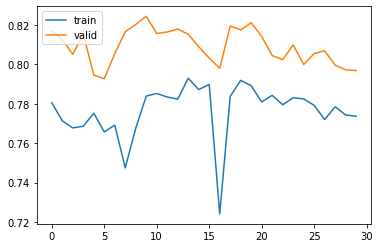

In [108]:
#plot_metrics(modelNN)
plt.plot(histoNN.history['AUC'])
plt.plot(histoNN.history['val_AUC'])
plt.legend(['train', 'valid'], loc='upper left')

In [109]:
# evaluate the keras model
l,fn,fp,tn,tp,pr,rap,auc = modelNN.evaluate(xvalid_nn, yvalid_nn)



9053/9053 [==============================] - 20s 2ms/step - loss: 0.4465 - fn: 393.0000 - fp: 31823.0000 - tn: 256914.0000 - tp: 555.0000 - precision: 0.0171 - recall: 0.5854 - AUC: 0.7968: 2s - loss: 0.4487 - fn: 337.0000 - fp: 28346.0000 - tn: 223480.0000 - tp: 477.0000 - preci


In [110]:
auc

0.7968168258666992

In [111]:
2*tp/(2*tp+fn*fp)

8.874640427153234e-05

RESEAU DE NEURONNES 2 AVEC TOMEK

In [117]:
modelNN2 = keras.Sequential(
    [
        keras.layers.Dense(
            15, activation="relu", input_shape=(xtrain_nn_tl.shape[-1],)
        ),
        keras.layers.Dense(5, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
modelNN2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 15)                330       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 6         
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


In [118]:
modelNN2.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
#on donne du poids aux fraudes ??? 
class_weight = {0: weight_for_0, 1: weight_for_1}

histoNN2=modelNN2.fit(
    xtrain_nn_tl,
    ytrain_nn_tl,
    batch_size=2048,
    #nb de fois où on passe le train pour ajuster les param ??
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(xvalid_nn, yvalid_nn),
    class_weight=class_weight,
)

Epoch 1/30
818/818 - 6s - loss: 0.5382 - fn: 1591.0000 - fp: 460416.0000 - tn: 1498848.0000 - tp: 3811.0000 - precision: 0.0082 - recall: 0.7055 - AUC: 0.8071 - val_loss: 0.6436 - val_fn: 215.0000 - val_fp: 87278.0000 - val_tn: 201459.0000 - val_tp: 733.0000 - val_precision: 0.0083 - val_recall: 0.7732 - val_AUC: 0.8191
Epoch 2/30
818/818 - 5s - loss: 0.5249 - fn: 1363.0000 - fp: 368588.0000 - tn: 1301939.0000 - tp: 3091.0000 - precision: 0.0083 - recall: 0.6940 - AUC: 0.8125 - val_loss: 0.5836 - val_fn: 230.0000 - val_fp: 82265.0000 - val_tn: 206472.0000 - val_tp: 718.0000 - val_precision: 0.0087 - val_recall: 0.7574 - val_AUC: 0.8232
Epoch 3/30
818/818 - 5s - loss: 0.5213 - fn: 1345.0000 - fp: 364984.0000 - tn: 1305543.0000 - tp: 3109.0000 - precision: 0.0084 - recall: 0.6980 - AUC: 0.8153 - val_loss: 0.5342 - val_fn: 260.0000 - val_fp: 68365.0000 - val_tn: 220372.0000 - val_tp: 688.0000 - val_precision: 0.0100 - val_recall: 0.7257 - val_AUC: 0.8227
Epoch 4/30
818/818 - 5s - loss: 0.

Epoch 27/30
818/818 - 5s - loss: 0.5078 - fn: 1346.0000 - fp: 335355.0000 - tn: 1335172.0000 - tp: 3108.0000 - precision: 0.0092 - recall: 0.6978 - AUC: 0.8263 - val_loss: 0.5811 - val_fn: 234.0000 - val_fp: 78917.0000 - val_tn: 209820.0000 - val_tp: 714.0000 - val_precision: 0.0090 - val_recall: 0.7532 - val_AUC: 0.8244
Epoch 28/30
818/818 - 4s - loss: 0.5075 - fn: 1322.0000 - fp: 341540.0000 - tn: 1328987.0000 - tp: 3132.0000 - precision: 0.0091 - recall: 0.7032 - AUC: 0.8260 - val_loss: 0.5473 - val_fn: 259.0000 - val_fp: 70706.0000 - val_tn: 218031.0000 - val_tp: 689.0000 - val_precision: 0.0097 - val_recall: 0.7268 - val_AUC: 0.8252
Epoch 29/30
818/818 - 5s - loss: 0.5088 - fn: 1319.0000 - fp: 343151.0000 - tn: 1327376.0000 - tp: 3135.0000 - precision: 0.0091 - recall: 0.7039 - AUC: 0.8262 - val_loss: 0.5007 - val_fn: 285.0000 - val_fp: 59860.0000 - val_tn: 228877.0000 - val_tp: 663.0000 - val_precision: 0.0110 - val_recall: 0.6994 - val_AUC: 0.8243
Epoch 30/30
818/818 - 4s - loss

Epoch 30/30
818/818 - 8s - loss: 6.0333e-07 - fn: 1304.0000 - fp: 350616.0000 - tn: 1319911.0000 - tp: 3150.0000 - precision: 0.0089 - recall: 0.7072 - AUC: 0.8281 - val_loss: 0.5557 - val_fn: 253.0000 - val_fp: 71724.0000 - val_tn: 217013.0000 - val_tp: 695.0000 - val_precision: 0.0096 - val_recall: 0.7331 - val_AUC: 0.8253


Epoch 30/30
818/818 - 7s - loss: 6.0386e-07 - fn: 1235.0000 - fp: 368341.0000 - tn: 1302186.0000 - tp: 3219.0000 - precision: 0.0087 - recall: 0.7227 - AUC: 0.8278 - val_loss: 0.5125 - val_fn: 274.0000 - val_fp: 65867.0000 - val_tn: 222870.0000 - val_tp: 674.0000 - val_precision: 0.0101 - val_recall: 0.7110 - val_AUC: 0.8199

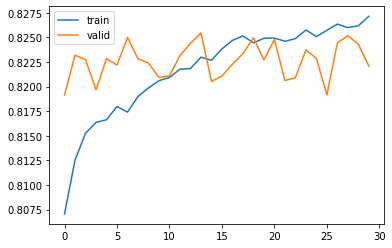

In [119]:
plt.plot(histoNN2.history['AUC'])
plt.plot(histoNN2.history['val_AUC'])
plt.legend(['train', 'valid'], loc='upper left')

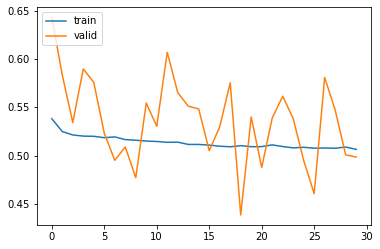

In [121]:
plt.plot(histoNN2.history['loss'])
plt.plot(histoNN2.history['val_loss'])
plt.legend(['train', 'valid'], loc='upper left')

In [175]:
# evaluate the keras model
metNN2 = modelNN2.evaluate(xvalid_nn, yvalid_nn,return_dict=True)

9053/9053 [==============================] - 20s 2ms/step - loss: 0.4984 - fn: 301.0000 - fp: 54529.0000 - tn: 234208.0000 - tp: 647.0000 - precision: 0.0117 - recall: 0.6825 - AUC: 0.8221


In [176]:
metNN2

{'loss': 0.49841228127479553,
 'fn': 301.0,
 'fp': 54529.0,
 'tn': 234208.0,
 'tp': 647.0,
 'precision': 0.01172611303627491,
 'recall': 0.6824894547462463,
 'AUC': 0.8220598101615906}

In [178]:

2*metNN2['tp']/(2*metNN2['tp']+metNN2['fn']+metNN2['fp'])

0.023056090086237616

In [136]:
# Instantiate a BaggingClassifier 'bc'
#bc = BaggingClassifier(base_estimator=modelNN2) #, n_estimators=300, n_jobs=-1
# Fit 'bc' to the training set
#bc.fit(xtrain_nn_tl, ytrain_nn_tl)


In [ ]:
# Predict test set labels
#y_predbag = bc.predict(X_test)
# Evaluate and print test-set accuracy
#accuracy = accuracy_score(yvalid_nn, y_predbag)
#print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [189]:
print(metrics.confusion_matrix(yvalid_nn,histoNN2,labels=["1", "0"]))

AttributeError: 'list' object has no attribute 'confusion_matrix'

In [195]:
predNN = modelNN2.predict_classes(xvalid_nn)

In [202]:
con_mat = tf.math.confusion_matrix(labels=yvalid_nn, predictions=predNN).numpy()

In [203]:
con_mat

array([[217013,  71724],
       [   253,    695]], dtype=int32)

In [ ]:
# Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=-1)
# Fit 'bc' to the training set
bc.fit(xtrain_nn_tl, ytrain_nn_tl)
# Predict test set labels
y_predbag = bc.predict(X_test)
# Evaluate and print test-set accuracy
accuracy = accuracy_score(yvalid_nn, y_predbag)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

In [179]:
modelNN3 = keras.Sequential(
    [
        keras.layers.Dense(
            15, activation="relu", input_shape=(xtrain_nn_tl.shape[-1],)
        ),
        keras.layers.Dense(5, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [182]:
xunder_nn=X_under
yunder_nn=np.array(y_under, dtype="uint8")

In [191]:

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='AUC')
]

modelNN3.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
#on donne du poids aux fraudes ??? 
#class_weight = {0: weight_for_0, 1: weight_for_1}

histoNN3=modelNN3.fit(
    xunder_nn,
    yunder_nn,
    batch_size=2048,
    #nb de fois où on passe le train pour ajuster les param ??
    epochs=15,
    verbose=2,
    callbacks=callbacks,
    validation_data=(xvalid_nn, yvalid_nn),
   # class_weight=class_weight,
)

Epoch 1/15
5/5 - 2s - loss: 838.1192 - fn: 1347.0000 - fp: 3095.0000 - tn: 1359.0000 - tp: 3107.0000 - precision: 0.5010 - recall: 0.6976 - AUC: 0.5009 - val_loss: 0.9560 - val_fn: 241.0000 - val_fp: 123292.0000 - val_tn: 165445.0000 - val_tp: 707.0000 - val_precision: 0.0057 - val_recall: 0.7458 - val_AUC: 0.7370
Epoch 2/15
5/5 - 1s - loss: 353.1983 - fn: 2275.0000 - fp: 1756.0000 - tn: 2698.0000 - tp: 2179.0000 - precision: 0.5537 - recall: 0.4892 - AUC: 0.5478 - val_loss: 1.0342 - val_fn: 211.0000 - val_fp: 128929.0000 - val_tn: 159808.0000 - val_tp: 737.0000 - val_precision: 0.0057 - val_recall: 0.7774 - val_AUC: 0.7482
Epoch 3/15
5/5 - 1s - loss: 312.6397 - fn: 3162.0000 - fp: 1088.0000 - tn: 3366.0000 - tp: 1292.0000 - precision: 0.5429 - recall: 0.2901 - AUC: 0.5234 - val_loss: 1.0439 - val_fn: 213.0000 - val_fp: 126565.0000 - val_tn: 162172.0000 - val_tp: 735.0000 - val_precision: 0.0058 - val_recall: 0.7753 - val_AUC: 0.7507
Epoch 4/15
5/5 - 1s - loss: 266.7139 - fn: 1195.0000

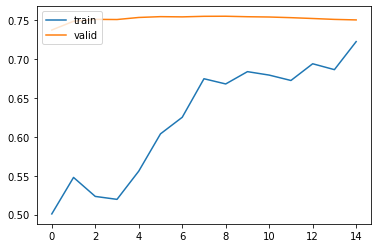

In [192]:
plt.plot(histoNN3.history['AUC'])
plt.plot(histoNN3.history['val_AUC'])
plt.legend(['train', 'valid'], loc='upper left')

In [193]:
# evaluate the keras model
metNN3 = modelNN3.evaluate(xvalid_nn, yvalid_nn,return_dict=True)

9053/9053 [==============================] - 17s 2ms/step - loss: 1.1193 - fn: 226.0000 - fp: 122554.0000 - tn: 166183.0000 - tp: 722.0000 - precision: 0.0059 - recall: 0.7616 - AUC: 0.7500


In [194]:
2*metNN3['tp']/(2*metNN3['tp']+metNN3['fn']+metNN3['fp'])

0.011624162802679031

In [195]:
metNN3

{'loss': 1.1192662715911865,
 'fn': 226.0,
 'fp': 122554.0,
 'tn': 166183.0,
 'tp': 722.0,
 'precision': 0.005856776610016823,
 'recall': 0.7616033554077148,
 'AUC': 0.749956488609314}

In [217]:
import IPython


In [219]:
#!pip install -q -U keras-tuner
import kerastuner as kt


In [283]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(xtrain_nn_tl.shape[-1],)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

In [284]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt',
                    overwrite=True)

In [285]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(xtrain_nn_tl,
             ytrain_nn_tl, 
            epochs = 10, 
             validation_data = (xvalid_nn, yvalid_nn), 
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 7 Complete [00h 03m 11s]
val_accuracy: 0.9967482089996338

Best val_accuracy So Far: 0.9967482089996338
Total elapsed time: 00h 22m 02s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
units             |448               |480               
learning_rate     |0.001             |0.001             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2
49587/52344 [===========================>..] - ETA: 6s - loss: 0.0181 - accuracy: 0.9972